##### Here I am implementing decision tree from scratch using the CART algorithm which uses the Gini impurity to split the features further. Lowest gini index is preferred for splitting .I will first calculate Gini index of each feature and then find the lowest. So first split will be like this and similarly repeat this process until the stopping criteria is reached.

##### Here I am using a sklearn inbuilt function to make a simple dataset for classification and testing.

In [71]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [101]:
# Making the dataset
X,y=make_classification(n_samples=750, n_features=2, n_redundant=0, n_informative=1,n_clusters_per_class=1, random_state=14)

C:\Users\aksha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

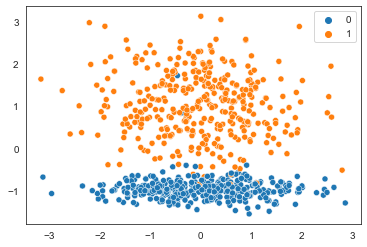

In [123]:
m = len(y)
y = np.reshape(y,(m, 1))
# appending labels and feature columns
training_data = np.append(X, y, 1)
sns.scatterplot(X[:,0],X[:,1],hue=y.reshape(-1))

In [103]:
training_data.shape

(750, 3)

In [104]:
# finding the unique values in a tree:
def unique_values(rows,col):
    return set([row[col] for row in rows])

In [105]:
unique_values(training_data,2)

{0.0, 1.0}

In [106]:
# defining the function to count unique values:
def class_counts(rows):
    counts={}
    for row in rows:
        label=row[-1]
        if label not in counts:
            counts[label]=0
        counts[label]+=1
    return counts

In [107]:
class_counts(training_data)

{0.0: 377, 1.0: 373}

In [108]:
# testing if a value is numeric
def is_numeric(value):
    return isinstance(value,int) or isinstance(value,float)

In [109]:
# implementing the class to compare function:
class Compare:
    def __init__(self,col,value):
        self.col=col
        self.value=value
    
    def match(self,ex):
        val=ex[self.col]
        if is_numeric(val):
            return val>self.value
        else:
            return val==self.value

In [110]:
# Partitioning the dataset:
def partition(rows,info):
    # for each row in dataset,check if it matches the info. If so, add it to 'true rows', otherwise, add it to 'false rows'
    true_d,false_d=[],[]
    for i in rows:
        if info.match(i):
            true_d.append(i)
        else:
            false_d.append(i)
    return true_d,false_d

In [111]:
# calculating gini impurity:
def gini_index(rows):
    counts=class_counts(rows)
    impurity=1
    for label in counts:
        prob_label=counts[label]/float(len(rows))
        impurity-=prob_label**2
    return impurity

In [112]:
# calculating the gain by subtracting the impurity of parent and weighted impurity of 2 childs:
def gain(left,right,current):
    p=float(len(left))/(len(left)+len(right))
    return current-p*gini_index(left)-(1-p)*gini_index(right)

In [113]:
# finding the best split by iterating over every feature and find the gain:
def best_split(rows):
    best_gain=0
    best_feature=None
    current_impurity=gini_index(rows)
    n=len(rows[0])-1 # no of columns
    for col in range(n):
        values=set([row[col] for row in rows])
        for val in values:
            feat=Compare(col,val)
            true_d,false_d=partition(rows,feat)
            # if this split do not divide further skipping it
            if len(true_d)==0 or len(false_d)==0:
                continue
            info_gain=gain(true_d,false_d,current_impurity)
            if info_gain>best_gain:
                best_gain,best_feature=info_gain,feat
    return best_gain,best_feature


In [114]:
# Data is classified by a leaf node so making a class for that
class Leaf:
    def __init__(self,rows):
        self.predictions=class_counts(rows)

In [115]:
# Defining a decision tree node for making a decision for a split
class Decision_Node:
    def __init__(self,feature,true_sub_tree,false_sub_tree):
        self.feature = feature
        self.true_sub_tree=true_sub_tree
        self.false_sub_tree = false_sub_tree

In [116]:
# a function to build the tree:
def build_tree(rows):
    gain,feature=best_split(rows)
    # if there is no gain so returning a leaf
    if gain==0:
        return Leaf(rows)
    # if some useful feature is there that has some gain so partition that.
    true_d,false_d=partition(rows,feature)
    # Recursively building true and false trees
    true_sub_tree=build_tree(true_d)
    false_sub_tree=build_tree(false_d)
    # It has the best feature
    return Decision_Node(feature,true_sub_tree,false_sub_tree)

In [117]:
# building a tree
dtree=build_tree(training_data)

In [118]:
# classify method:
def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions
    if node.feature.match(row):
        return classify(row,node.true_sub_tree)
    else:
        return classify(row,node.false_sub_tree)

In [119]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [120]:
# testing a leaf value by printing the prediction there by calculating probability
print_leaf(classify(training_data[1], dtree))

{1.0: '100%'}